<a href="https://colab.research.google.com/github/AbderrhmanAbdellatif/CRM/blob/master/Customer%20Lifetime%20Value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Calculating Lifetime Value is the easy part. First we need to select a time window. It can be anything like 3, 6, 12, 24 months. By the equation below, we can have Lifetime Value for each customer in that specific time window:

### Lifetime Value: Total Gross Revenue - Total Cost    >> ne demek istemis , Total Gross Revenue nedir ,   Total Cost nedir

### This equation now gives us the historical lifetime value. If we see some customers having very high negative lifetime value historically, it could be too late to take an action. At this point, we need to predict the future with machine learning:

In [4]:
#import libraries
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
#import machine learning related libraries
from sklearn.svm import SVC 
from sklearn.multioutput import MultiOutputClassifier 
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
import xgboost as xgb 
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import plotly.offline as pyoff
import plotly.graph_objs as go
import xgboost as xgb
import datetime as dt
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import xgboost as xgb

#initate plotly
pyoff.init_notebook_mode()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
#read data from csv and redo the data work we done before
tx_data = pd.read_csv('https://raw.githubusercontent.com/AbderrhmanAbdellatif/CRM/master/OnlineRetail.csv',encoding= 'unicode_escape')
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])
tx_uk = tx_data.query("Country=='United Kingdom'").reset_index(drop=True)
tx_uk.head()

InvoiceNo StockCode  ... CustomerID         Country
0    536365    85123A  ...    17850.0  United Kingdom
1    536365     71053  ...    17850.0  United Kingdom
2    536365    84406B  ...    17850.0  United Kingdom
3    536365    84029G  ...    17850.0  United Kingdom
4    536365    84029E  ...    17850.0  United Kingdom

[5 rows x 8 columns]

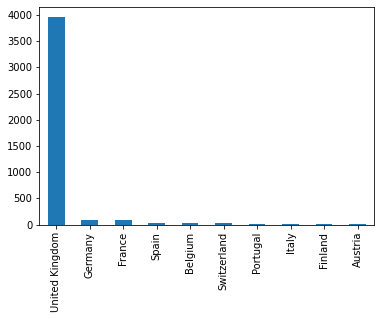

In [6]:
filtered_data=tx_data[['Country','CustomerID']].drop_duplicates()
filtered_data.Country.value_counts()[:10].plot(kind='bar')

In [7]:
tx_data.describe()

Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000

In [8]:
uk_data = tx_data.describe()[(tx_data.describe()['Quantity']>0)]
uk_data=tx_data[['CustomerID','InvoiceDate','InvoiceNo','Quantity','UnitPrice']]
uk_data['TotalPrice'] = uk_data['Quantity'] * uk_data['UnitPrice']
uk_data['InvoiceDate'].min(),uk_data['InvoiceDate'].max()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:50:00'))

In [9]:
PRESENT = dt.datetime(2011,12,10)
uk_data['InvoiceDate'] = pd.to_datetime(uk_data['InvoiceDate'])
uk_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



CustomerID         InvoiceDate InvoiceNo  Quantity  UnitPrice  TotalPrice
0     17850.0 2010-12-01 08:26:00    536365         6       2.55       15.30
1     17850.0 2010-12-01 08:26:00    536365         6       3.39       20.34
2     17850.0 2010-12-01 08:26:00    536365         8       2.75       22.00
3     17850.0 2010-12-01 08:26:00    536365         6       3.39       20.34
4     17850.0 2010-12-01 08:26:00    536365         6       3.39       20.34

In [0]:
rfm= uk_data.groupby('CustomerID').agg({'InvoiceDate': lambda date: (PRESENT - date.max()).days,
                                        'InvoiceNo': lambda num: len(num),
                                        'TotalPrice': lambda price: price.sum()})

In [11]:
rfm.columns

Index(['InvoiceDate', 'InvoiceNo', 'TotalPrice'], dtype='object')

In [12]:
rfm.columns=['recency','frequency','monetary']
rfm['recency'] = rfm['recency'].astype(int)
rfm

recency  frequency  monetary
CustomerID                              
12346.0         325          2      0.00
12347.0           2        182   4310.00
12348.0          75         31   1797.24
12349.0          18         73   1757.55
12350.0         310         17    334.40
...             ...        ...       ...
18280.0         277         10    180.60
18281.0         180          7     80.82
18282.0           7         13    176.60
18283.0           3        756   2094.88
18287.0          42         70   1837.28

[4372 rows x 3 columns]

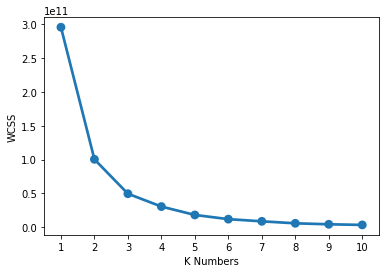

In [13]:
wcss = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters= k, init= 'k-means++', max_iter= 300)
    kmeans.fit(rfm)
    wcss[k] = kmeans.inertia_# plot the WCSS values
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.xlabel('K Numbers')
plt.ylabel('WCSS')
plt.show()

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat


# -----------------------------------------------------------------------

# select random points
def init_centroids(X, k):
    m, n = X.shape
    centroids = np.zeros((k, n))
    idx = np.random.randint(0, m, k)

    for i in range(k):
        centroids[i, :] = X.iloc[idx[i], :]

    return centroids


# centroid function
def find_closest_centroids(X, centroids):
    m = X.shape[0]
    k = centroids.shape[0]
    idx = np.zeros(m)

    for i in range(m):
        min_dist = 1000000
        for j in range(k):
            dist = np.sum((X.iloc[i, :] - centroids[j, :]) ** 2)
            if dist < min_dist:
                min_dist = dist
                idx[i] = j

    return idx


# centroid maker
def findClosestCentroids(X, centroids):
    """
    Returns the closest centroids in idx for a dataset X
    where each row is a single example. idx = m x 1 vector
    of centroid assignments (i.e. each entry in range [1..K])
    Args:
        X        : array(# training examples, n)
        centroids: array(K, n)
    Returns:
        idx      : array(# training examples, 1)
    """
    # Set K size.
    K = centroids.shape[0]

    # Initialise idx.
    idx = np.zeros((X.shape[0], 1), dtype=np.int8)

    # Iterate over every example, find its closest centroid, and store
    # the index inside idx at the appropriate location. Concretely,
    # idx[i] should contain the index of the centroid closest to
    # example i. Hence, it should be a value in the range 1..K.
    
#     # Iterate over training examples.
#     for i in range(X.shape[0]):
#         # Set norm distance to infinity.
#         min_dst = math.inf
#         # Iterate over centroids.
#         for k in range(K):
#             # Compute the norm distance.
#             dst = np.linalg.norm(X[i,:] - centroids[k,:], axis=0)
#             if dst < min_dst:
#                 min_dst = dst
#                 idx[i] = k
    
    # Alternative partial vectorized solution.
    # Iterate over training examples.
    for i in range(X.shape[0]):
        distances = np.linalg.norm(X[i] - centroids, axis=1)
        # argmin returns the indices of the minimum values along an axis,
        # replacing the need for a for-loop and if statement.
        min_dst = np.argmin(distances)
        idx[i] = min_dst
    
    return idx

def compute_centroids(X, idx, K):
    """
    Returns the new centroids by computing the means
    of the data points assigned to each centroid. It is
    given a dataset X where each row is a single data point,
    a vector idx of centroid assignments (i.e. each entry
    in range [1..K]) for each example, and K, the number of
    centroids. A matrix centroids is returned, where each row
    of centroids is the mean of the data points assigned to it.
    Args:
        X        : array(# training examples, 2)
        idx      : array(# training examples, 1)
        K        : int, # of centroids
    Returns:
        centroids: array(# of centroids, 2)
    """
    # Create useful variables
    m, n = X.shape
    
    # Initialize centroids matrix.
    centroids = np.zeros((K, n))
    # Iterate over every centroid and compute mean of all points that
    # belong to it. Concretely, the row vector centroids[k,:] should
    # contain the mean of the data points assigned to centroid k.
    
#     # Iterate over centroids.
#     for k in range(K):
#         # Iterate over training examples.
#         for i in range(m):
#             if idx[i] == k:
#                 points = X[i]
#                 centroids[k] = np.mean(points, axis=0)
    
    # Alternative partial vectorized solution.
    for k in range(K):
        centroids[k, :] = np.mean(X.iloc[idx.ravel() == k, :], axis=0)
    
    return centroids


# k means function
def run_k_means(X, initial_centroids, max_iters):
    m, n = X.shape
    k = initial_centroids.shape[0]
    idx = np.zeros(m)
    centroids = initial_centroids

    for i in range(max_iters):
        idx = find_closest_centroids(X, centroids)
        centroids = compute_centroids(X, idx, k)

    return idx, centroids


def pca(X):
    # normalize the features
    X = (X - X.mean()) / X.std()

    # compute the covariance matrix
    X = np.matrix(X)
    cov = (X.T * X) / X.shape[0]
    #    print('cov \n', cov)
    #    print()
    # perform SVD
    U, S, V = np.linalg.svd(cov)  # singular value decomposition

    return U, S, V


def project_data(X, U, k):
    U_reduced = U[:, :k]
    return np.dot(X, U_reduced)


def recover_data(Z, U, k):
    U_reduced = U[:, :k]
    return np.dot(Z, U_reduced.T)


# -----------------------------------------------------------------------


(4372, 3)
[[ 16.    39.   642.8 ]
 [127.    18.   300.36]
 [  1.     9.   216.3 ]]
[1. 0. 0. ... 2. 0. 0.]
[[  54.34772552  141.57632999 3031.97872899]
 [ 189.68852459   23.81229508  282.48677131]
 [  50.1702509    18.86917563  162.14897849]]

K-Means iteration 0/30...

[0. 0. 0. ... 0. 0. 0.]
 
[[ 16.    39.   642.8 ]
 [127.    18.   300.36]
 [  1.     9.   216.3 ]]

K-Means iteration 1/30...

[1. 0. 0. ... 2. 0. 0.]
 
[[  54.34772552  141.57632999 3031.97872899]
 [ 189.68852459   23.81229508  282.48677131]
 [  50.1702509    18.86917563  162.14897849]]

K-Means iteration 2/30...

[1. 0. 0. ... 2. 0. 0.]
 
[[  38.02505527  214.77671334 5068.19908696]
 [ 129.45930736   44.21515152  566.02891039]
 [  70.55602837   18.78014184  163.1104539 ]]

K-Means iteration 3/30...

[2. 0. 0. ... 2. 0. 0.]
 
[[  35.92724046  238.09760426 5815.57779148]
 [  84.73355084   60.67591082  797.41846819]
 [ 145.14793741   19.13940256  198.76036984]]

K-Means iteration 4/30...

[2. 0. 0. ... 2. 0. 0.]
 
[[  33

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



[2. 0. 1. ... 2. 1. 1.]
 
[[  28.76303318  319.91153239 8760.38355608]
 [  50.22303665  112.56544503 1670.07786387]
 [ 120.05136494   34.77909483  416.60153125]]

K-Means iteration 22/30...

[2. 0. 1. ... 2. 1. 1.]
 
[[  28.77020602  320.50713154 8779.70542155]
 [  49.795383    112.79748164 1674.79271773]
 [ 120.08034433   34.82532281  417.50151829]]

K-Means iteration 23/30...

[2. 0. 1. ... 2. 1. 1.]
 
[[  28.77020602  320.50713154 8779.70542155]
 [  49.67721519  113.00316456 1678.11787975]
 [ 119.99462943   34.89509488  418.6236817 ]]

K-Means iteration 24/30...

[2. 0. 1. ... 2. 1. 1.]
 
[[  28.75396825  320.36190476 8789.46855714]
 [  49.34358431  113.67550371 1683.12817603]
 [ 119.95248303   34.94283673  419.97526009]]

K-Means iteration 25/30...

[2. 0. 1. ... 2. 1. 1.]
 
[[  28.75396825  320.36190476 8789.46855714]
 [  49.47649573  113.90491453 1687.88805556]
 [ 119.73200285   35.06272274  421.53863257]]

K-Means iteration 26/30...

[2. 0. 1. ... 2. 1. 1.]
 
[[  28.78696343  32

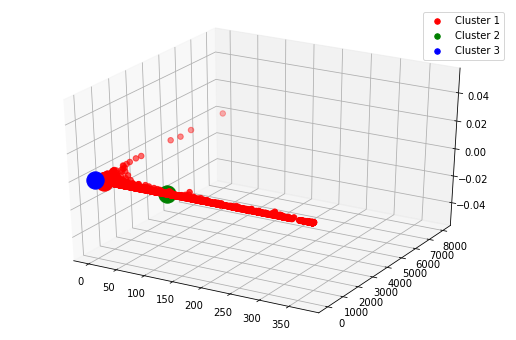

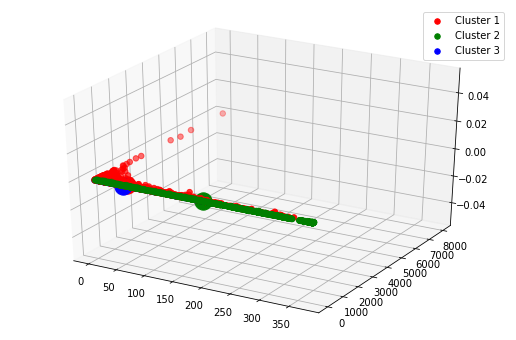

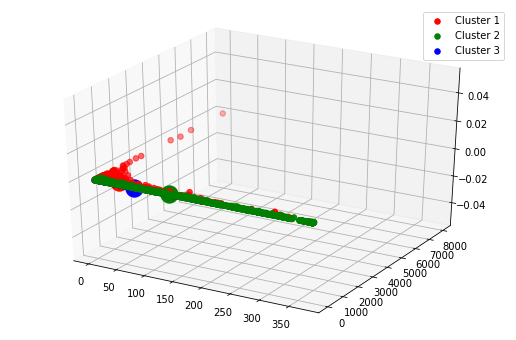

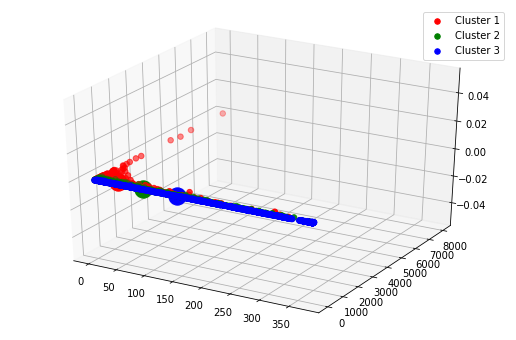

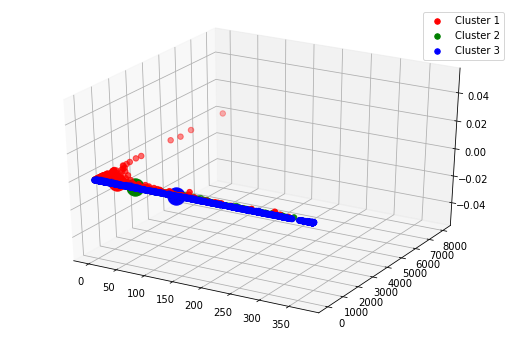

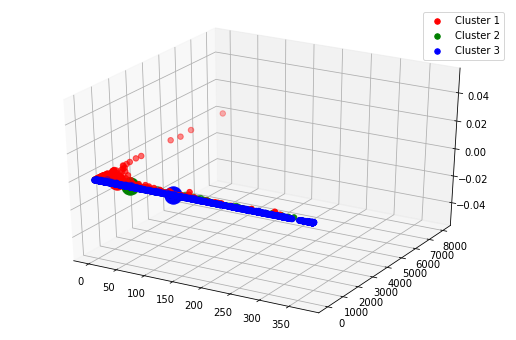

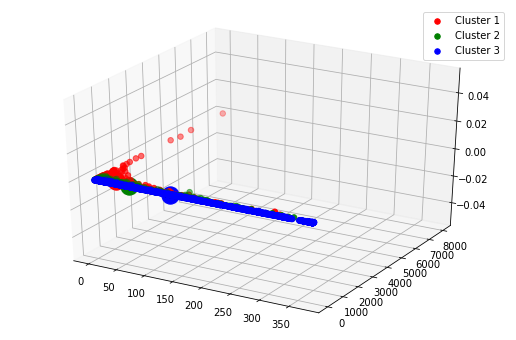

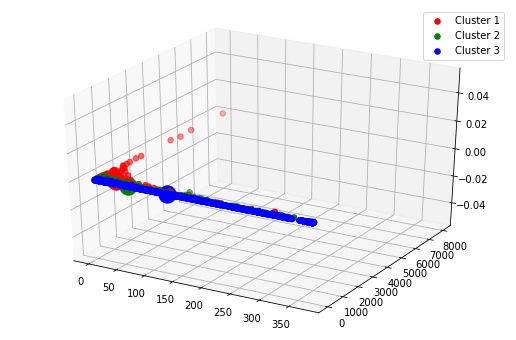

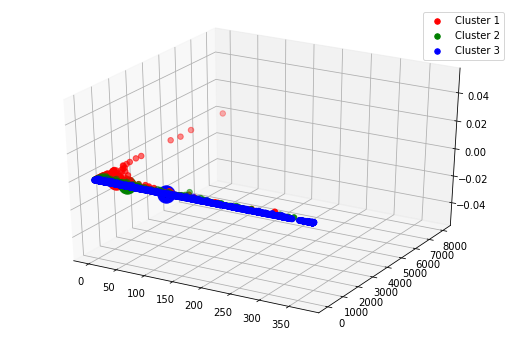

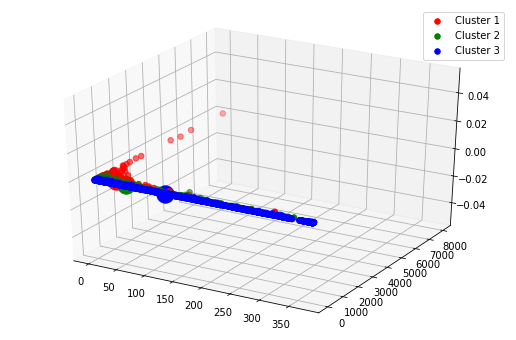

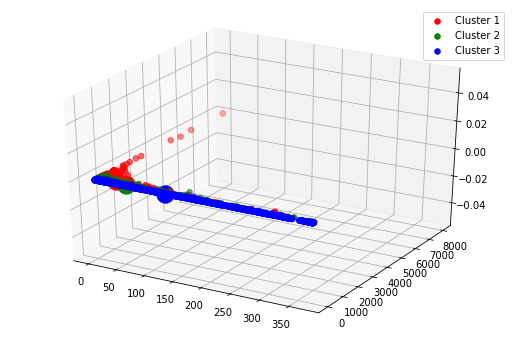

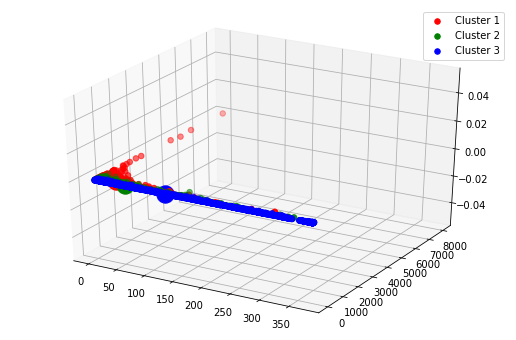

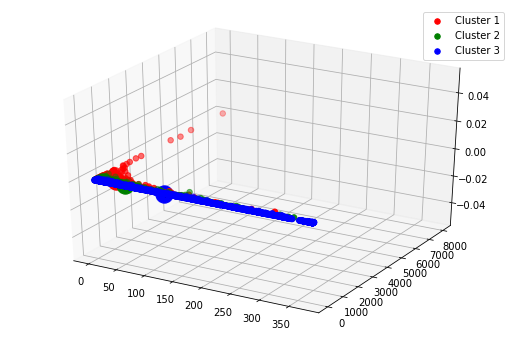

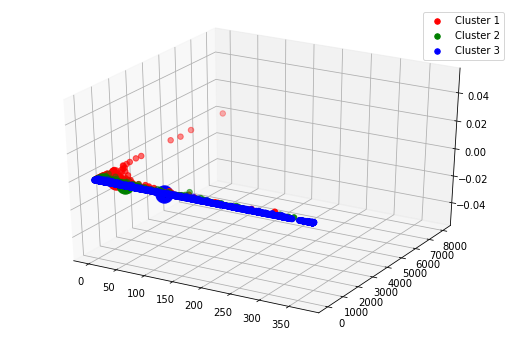

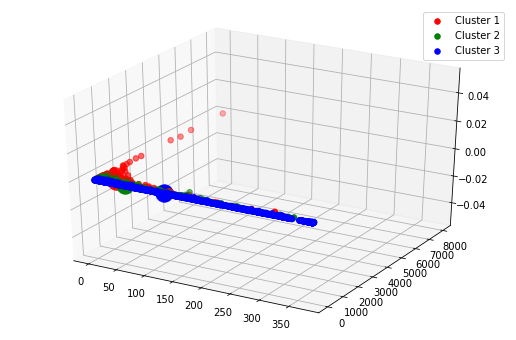

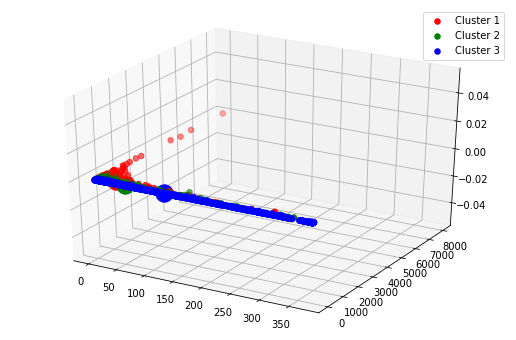

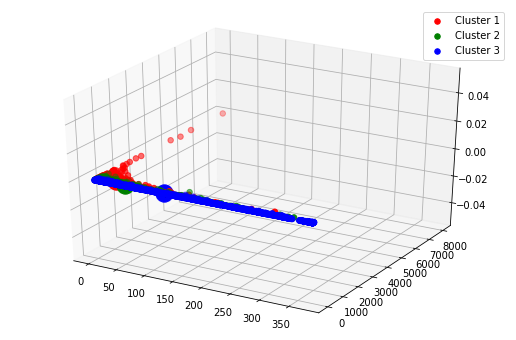

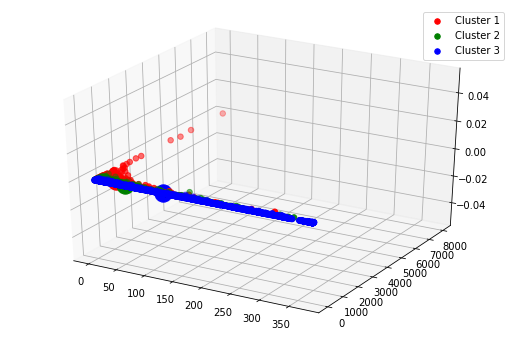

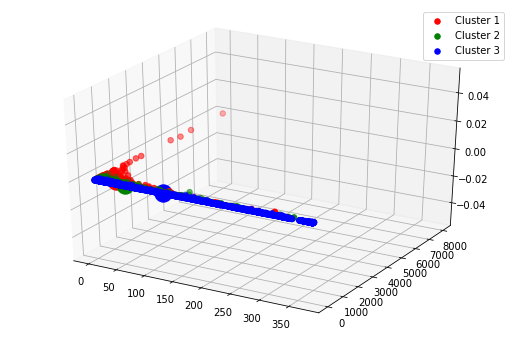

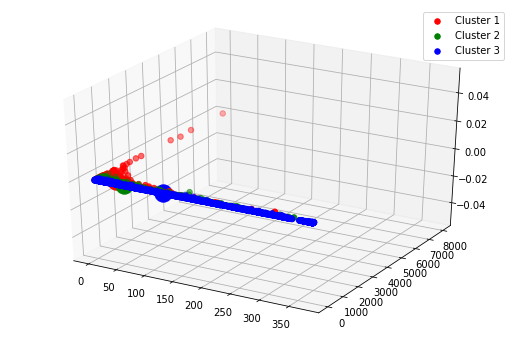

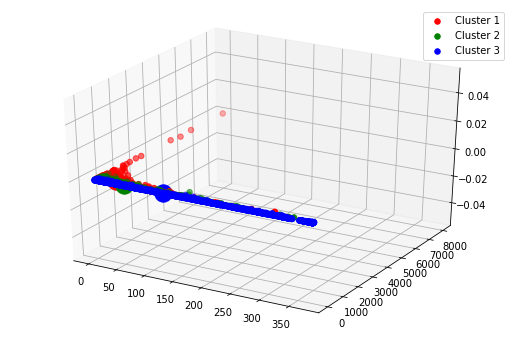

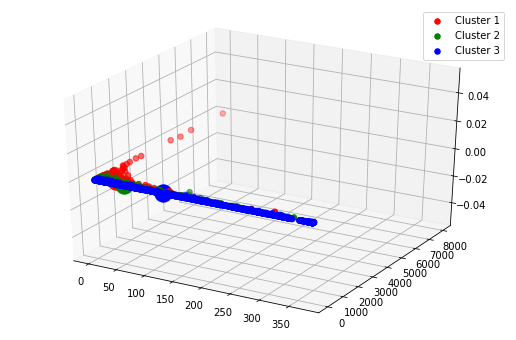

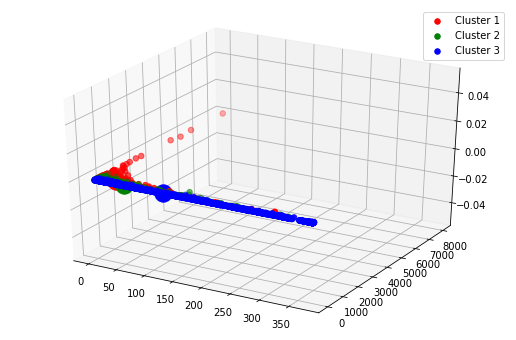

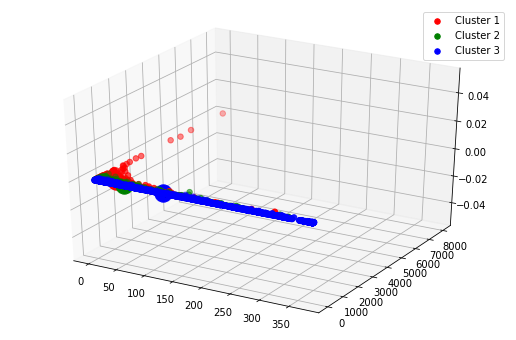

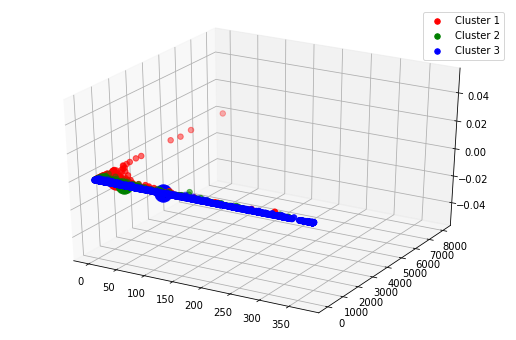

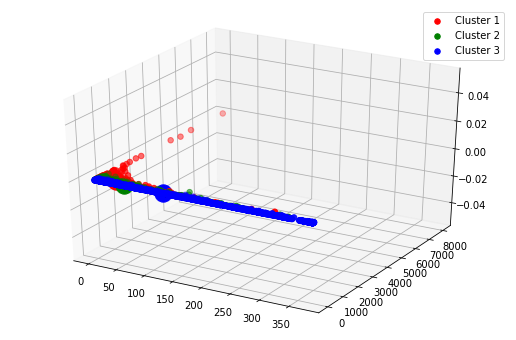

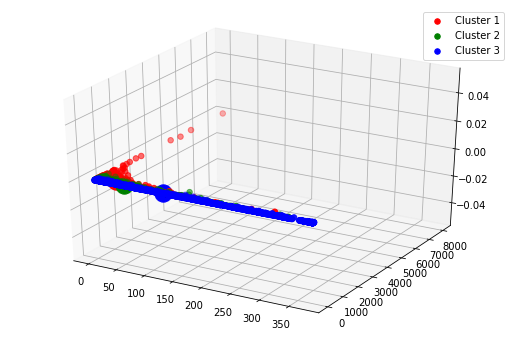

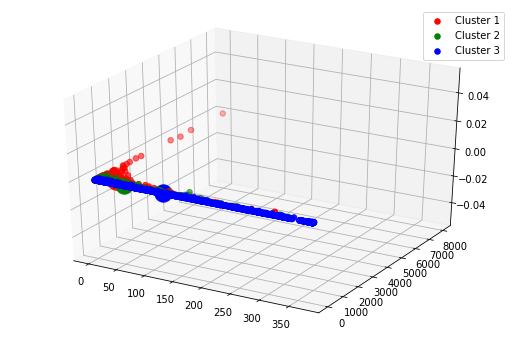

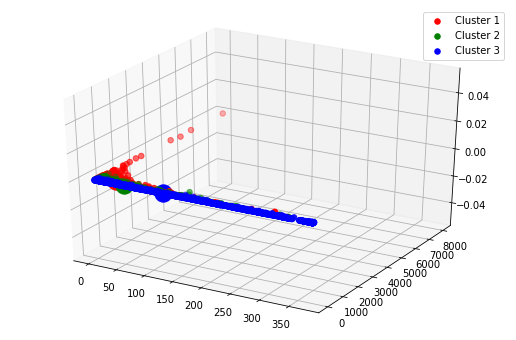

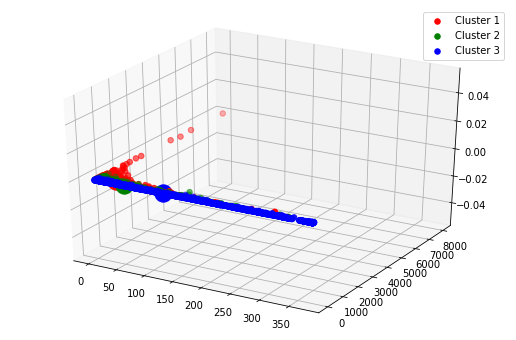

In [18]:

# load data

#print(rfm)
#print(f1)
print(rfm.shape)
# classify points
X = rfm
#initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])
#initial_centroids = np.array([[8, 0], [8, 6], [0, 3]])
initial_centroids = init_centroids(X, 3)
print(initial_centroids)

idx = find_closest_centroids(X, initial_centroids)
print(idx)

# calculate new centroid
c = compute_centroids(X, idx, 3)
print(c)

for x in range(30):
    # apply k means
    print( )
    print('K-Means iteration {}/{}...'.format(x, 30))
    print( )
    idx, centroids = run_k_means(X, initial_centroids, x)
    print(idx)
    print(" ")
    print(centroids)
    cluster1 = X.iloc[np.where(idx == 0)[0], :]
    cluster2 = X.iloc[np.where(idx == 1)[0], :]
    cluster3 = X.iloc[np.where(idx == 2)[0], :]
    fig, ax = plt.subplots(figsize=(9, 6)) , plt.axes(projection='3d')
    ax.scatter(cluster1.iloc[:, 0], cluster1.iloc[:, 1], s=30, color='r', label='Cluster 1')
    ax.scatter(centroids[0, 0], centroids[0, 1], s=300, color='r')
    ax.scatter(cluster2.iloc[:, 0], cluster2.iloc[:, 1], s=30, color='g', label='Cluster 2')
    ax.scatter(centroids[1, 0], centroids[1, 1], s=300, color='g')
    ax.scatter(cluster3.iloc[:, 0], cluster3.iloc[:, 1], s=30, color='b', label='Cluster 3')
    ax.scatter(centroids[2, 0], centroids[2, 1], s=300, color='b')
    ax.legend()


(4372, 3)
[[4.200000e+01 1.670000e+02 1.758826e+04]
 [9.900000e+01 1.800000e+01 3.052800e+02]
 [4.300000e+01 7.000000e+00 2.505500e+02]
 [1.720000e+02 1.600000e+01 1.131200e+02]
 [0.000000e+00 5.400000e+01 2.085080e+03]]
[3. 0. 4. ... 2. 4. 4.]
[[  26.59210526  345.9943609  9897.03084774]
 [ 101.37184874   48.85871849  616.11671901]
 [  34.56965174   22.48507463  214.54149254]
 [ 215.62461059   12.80996885  121.96755452]
 [  45.85874439  126.08744395 1902.70215247]]

K-Means iteration 0/30...

[0. 0. 0. ... 0. 0. 0.]
 
[[4.200000e+01 1.670000e+02 1.758826e+04]
 [9.900000e+01 1.800000e+01 3.052800e+02]
 [4.300000e+01 7.000000e+00 2.505500e+02]
 [1.720000e+02 1.600000e+01 1.131200e+02]
 [0.000000e+00 5.400000e+01 2.085080e+03]]

K-Means iteration 1/30...

[3. 0. 4. ... 2. 4. 4.]
 
[[  26.59210526  345.9943609  9897.03084774]
 [ 101.37184874   48.85871849  616.11671901]
 [  34.56965174   22.48507463  214.54149254]
 [ 215.62461059   12.80996885  121.96755452]
 [  45.85874439  126.08744395 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



[3. 0. 1. ... 3. 1. 1.]
 
[[   23.58082192   407.85205479 12820.5029863 ]
 [   49.6570122    113.80792683  1699.90650915]
 [   73.57575758    63.4077135    814.82453811]
 [  140.74352195    23.21099947   259.7414019 ]
 [   34.88140162   189.65498652  3037.54350674]]

K-Means iteration 22/30...

[3. 0. 1. ... 3. 1. 1.]
 
[[   23.61690141   412.16901408 13069.14692958]
 [   49.33281734   114.53869969  1723.97797214]
 [   72.87398005    64.10335449   824.19251315]
 [  140.72957301    23.22509225   260.62608382]
 [   34.49056604   193.40431267  3081.77051482]]

K-Means iteration 23/30...

[3. 0. 1. ... 3. 1. 1.]
 
[[   23.90229885   415.42241379 13250.54902299]
 [   48.68710692   117.39937107  1748.68672956]
 [   72.74303684    64.35220126   834.72655166]
 [  140.39853173    23.44887257   262.06037284]
 [   33.71467391   193.62771739  3119.32122554]]

K-Means iteration 24/30...

[3. 0. 1. ... 3. 1. 1.]
 
[[   23.97101449   415.59710145 13330.48597101]
 [   48.44761905   118.60952381  1767.

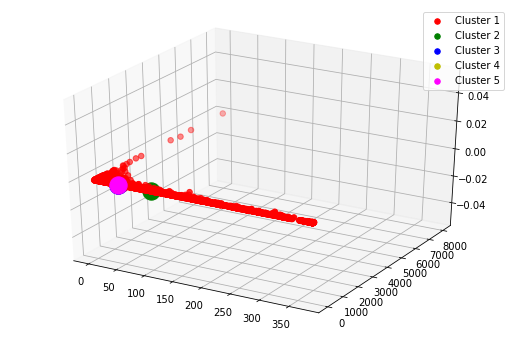

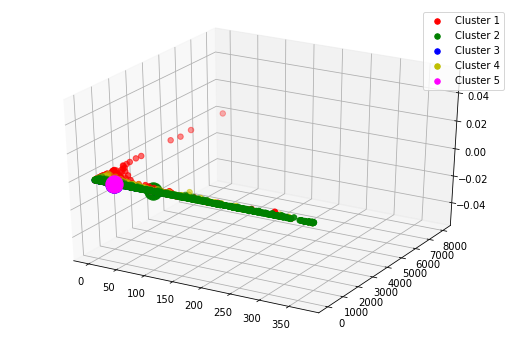

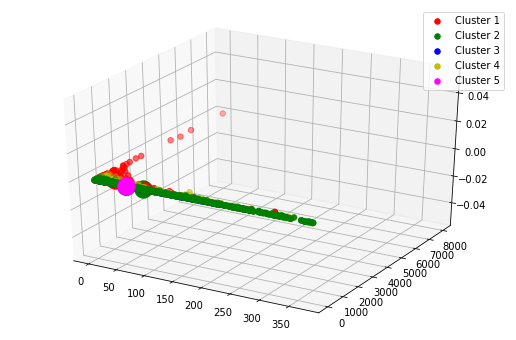

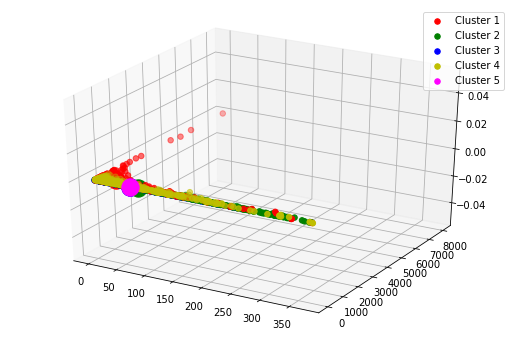

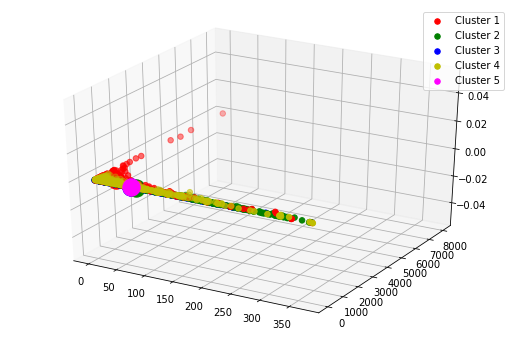

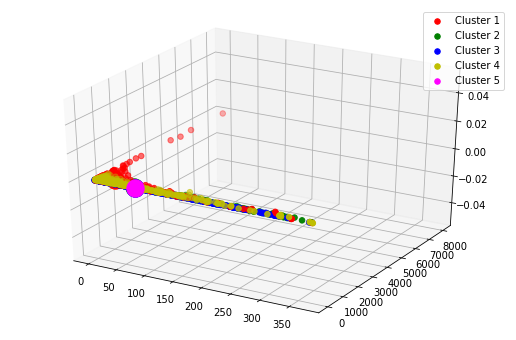

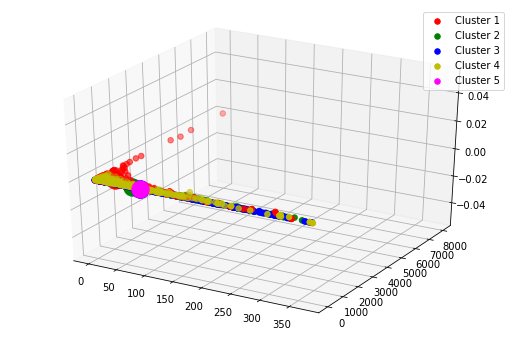

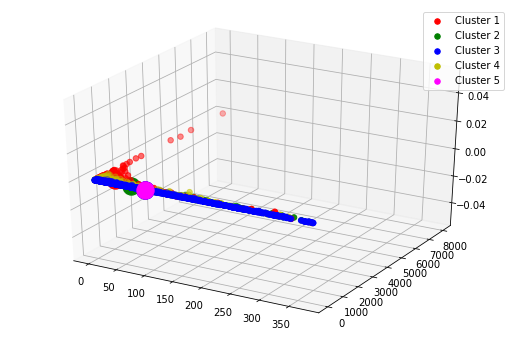

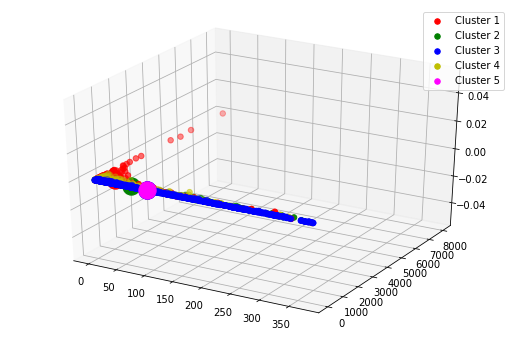

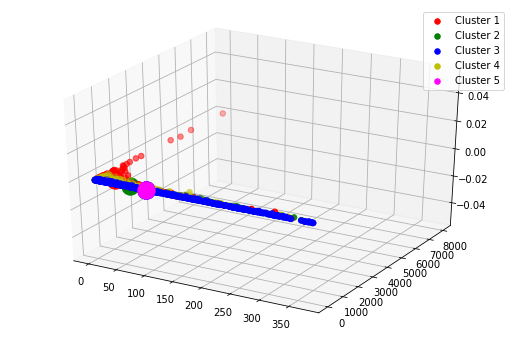

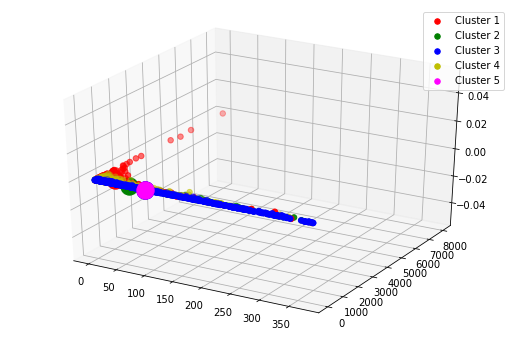

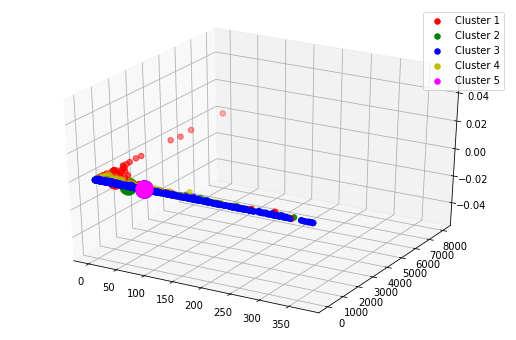

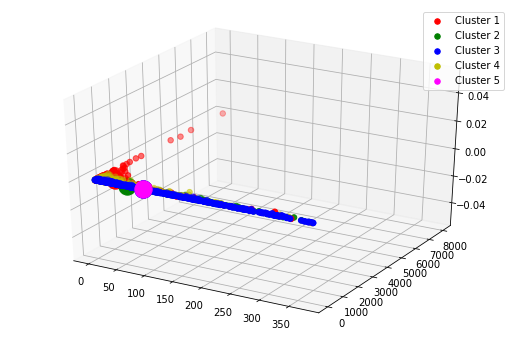

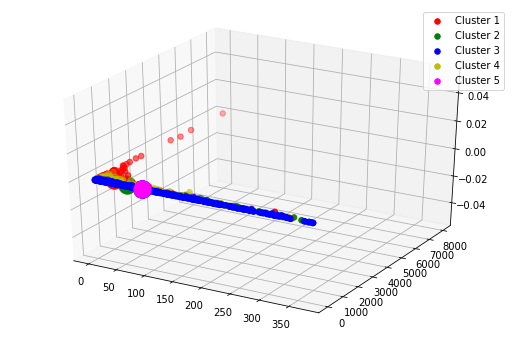

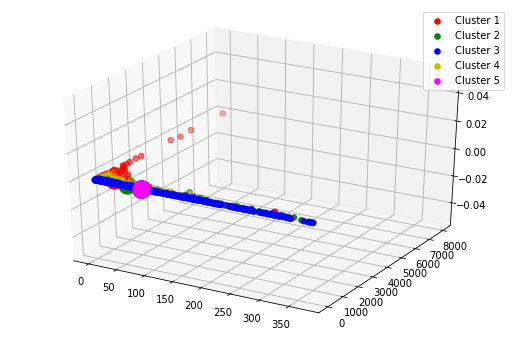

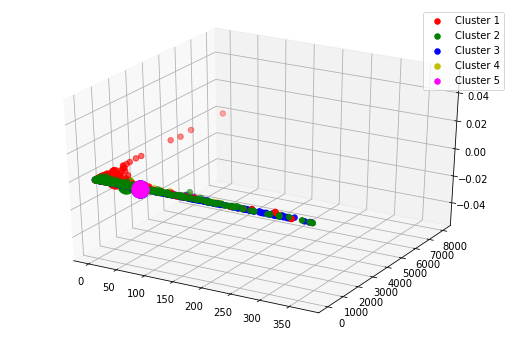

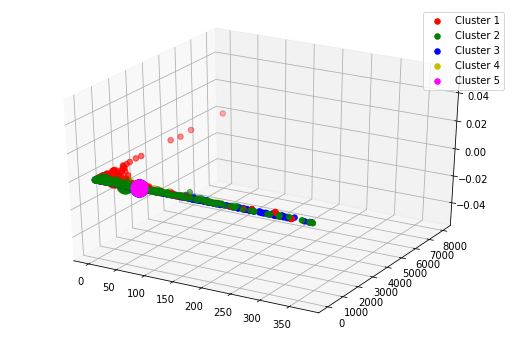

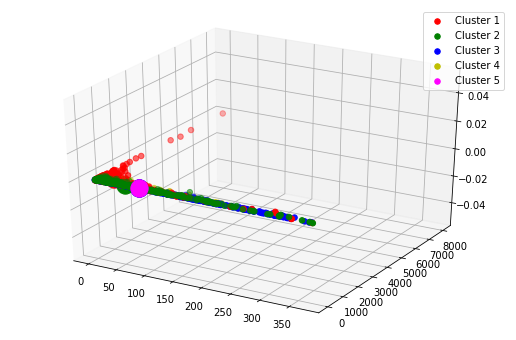

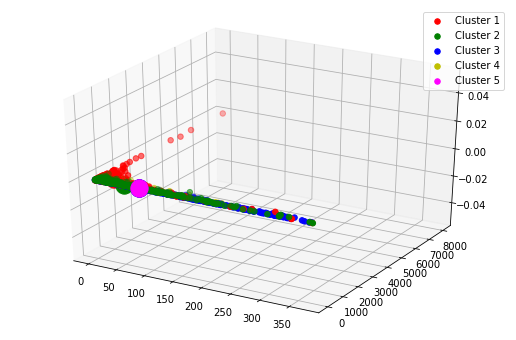

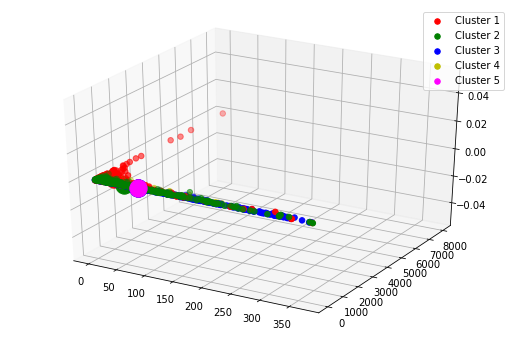

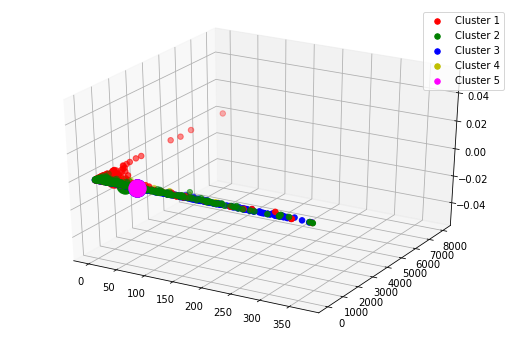

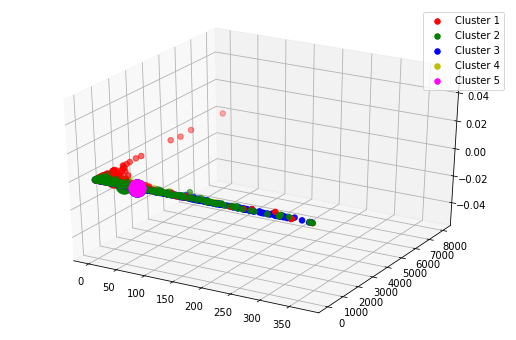

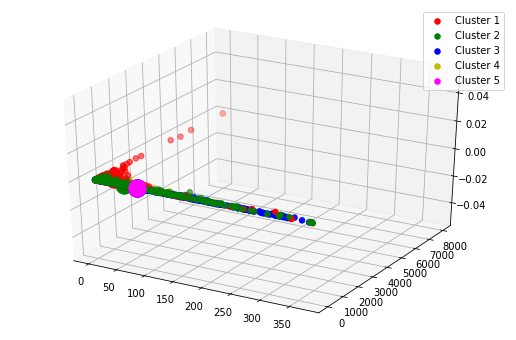

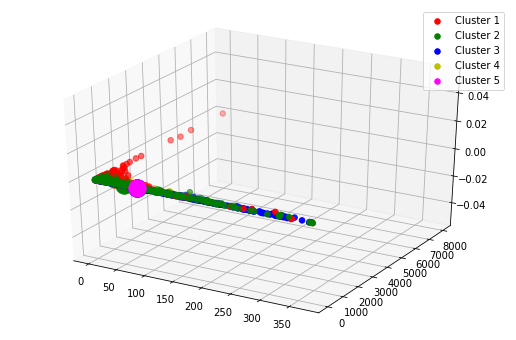

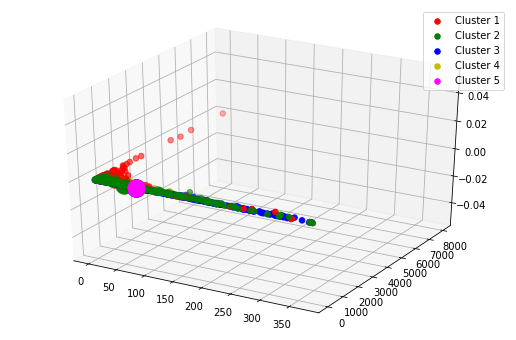

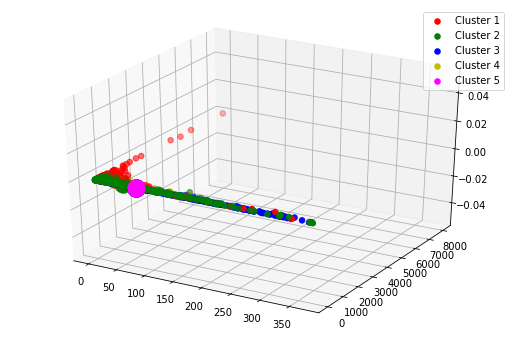

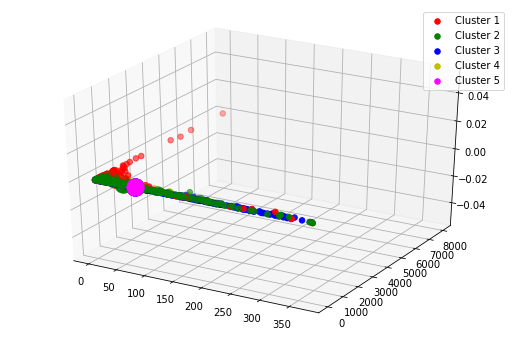

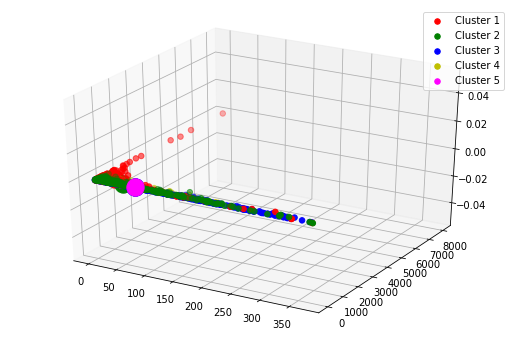

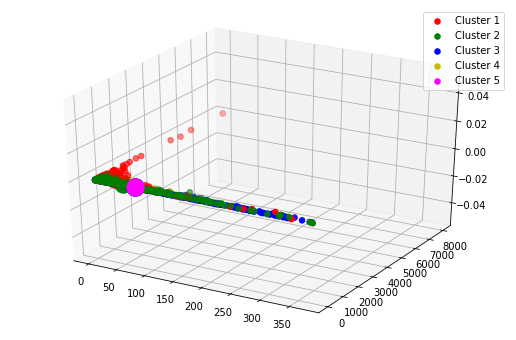

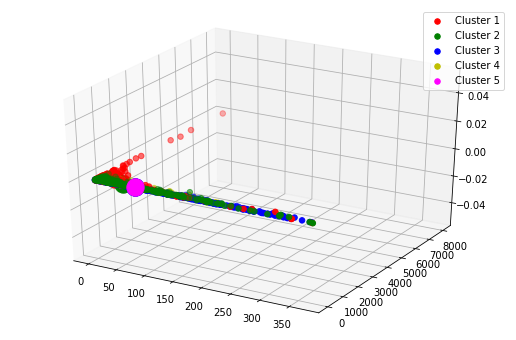

In [19]:

# load data

#print(rfm)
#print(f1)
print(rfm.shape)
# classify points
X = rfm
#initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])
#initial_centroids = np.array([[8, 0], [8, 6], [0, 3]])
initial_centroids = init_centroids(X, 4)
print(initial_centroids)

idx = find_closest_centroids(X, initial_centroids)
print(idx)

# calculate new centroid
c = compute_centroids(X, idx, 4)
print(c)

for x in range(30):
    # apply k means
    print( )
    print('K-Means iteration {}/{}...'.format(x, 30))
    print( )
    idx, centroids = run_k_means(X, initial_centroids, x)
    print(idx)
    print(" ")
    print(centroids)
    cluster1 = X.iloc[np.where(idx == 0)[0], :]
    cluster2 = X.iloc[np.where(idx == 1)[0], :]
    cluster3 = X.iloc[np.where(idx == 2)[0], :]
    cluster4 = X.iloc[np.where(idx == 4)[0], :]
    cluster5 = X.iloc[np.where(idx == 5)[0], :]
    
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.scatter(cluster1.iloc[:, 0], cluster1.iloc[:, 1], s=30, color='r', label='Cluster 1')
    ax.scatter(centroids[0, 0], centroids[0, 1], s=300, color='r')
    ax.scatter(cluster2.iloc[:, 0], cluster2.iloc[:, 1], s=30, color='g', label='Cluster 2')
    ax.scatter(centroids[1, 0], centroids[1, 1], s=300, color='g')
    ax.scatter(cluster3.iloc[:, 0], cluster3.iloc[:, 1], s=30, color='b', label='Cluster 3')
    ax.scatter(centroids[2, 0], centroids[2, 1], s=300, color='b')
    ax.scatter(cluster4.iloc[:, 0], cluster4.iloc[:, 1], s=30, color='y', label='Cluster 4')
    ax.scatter(centroids[2, 0], centroids[2, 1], s=300, color='#FF00FF')
    ax.legend()


# Create 3m and 6m dataframes

In [0]:
tx_3m = tx_uk[(tx_uk.InvoiceDate < datetime(2011,6,1)) & (tx_uk.InvoiceDate >= datetime(2011,3,1))].reset_index(drop=True)
tx_3m.head()

In [0]:
tx_6m = tx_uk[(tx_uk.InvoiceDate >= datetime(2011,6,1)) & (tx_uk.InvoiceDate < datetime(2011,12,1))].reset_index(drop=True)
tx_6m.head()

In [0]:
tx_user = pd.DataFrame(tx_3m['CustomerID'].unique())
tx_user.columns = ['CustomerID']
tx_user.head()

# Order cluster method

In [0]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

# calculate recency score

In [0]:
tx_max_purchase = tx_3m.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')

In [0]:
tx_user.head()

In [0]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

In [0]:
tx_user.head()

# calcuate frequency score

In [0]:
tx_frequency = tx_3m.groupby('CustomerID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['CustomerID','Frequency']
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')

In [0]:
tx_user.head()

In [0]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

In [0]:
tx_user.head()

## calcuate revenue score


In [0]:
tx_3m['Revenue'] = tx_3m['UnitPrice'] * tx_3m['Quantity']
tx_revenue = tx_3m.groupby('CustomerID').Revenue.sum().reset_index()
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')

kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

## overall scoring


In [0]:
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [0]:
tx_user.head(10)

## calculate revenue and create a new dataframe for it

In [0]:
tx_6m['Revenue'] = tx_6m['UnitPrice'] * tx_6m['Quantity']
tx_user_6m = tx_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
tx_user_6m.columns = ['CustomerID','m6_Revenue']

In [0]:
tx_user_6m.head()

In [0]:
#plot LTV histogram
plot_data = [
    go.Histogram(
        x=tx_user_6m.query('m6_Revenue < 10000')['m6_Revenue']
    )
]

plot_layout = go.Layout(
        title='6m Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

### Histogram clearly shows we have customers with negative LTV. We have some outliers too. Filtering out the outliers makes sense to have a proper machine learning model.

# We will merge our 3 months and 6 months dataframes to see correlations between LTV and the feature set we have.

In [0]:
tx_merge = pd.merge(tx_user, tx_user_6m, on='CustomerID', how='left')

In [0]:
tx_merge.head()

In [0]:
tx_graph = tx_merge.query("m6_Revenue < 30000")

In [0]:
tx_graph.head()

# The code below merges our feature set and LTV data and plots LTV vs overall RFM score:

In [0]:
plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Low-Value'")['m6_Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Mid-Value'")['m6_Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'High-Value'")['m6_Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "6m LTV"},
        xaxis= {'title': "RFM Score"},
        title='LTV'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [0]:
#remove outliers
tx_merge = tx_merge[tx_merge['m6_Revenue']<tx_merge['m6_Revenue'].quantile(0.99)] #  neden quantile(0.99) sectin ? 

In [0]:
tx_merge.head()

In [0]:
#creating 3 clusters  , arastir ?  
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_merge[['m6_Revenue']])
tx_merge['LTVCluster'] = kmeans.predict(tx_merge[['m6_Revenue']])

In [0]:
tx_merge.head()

In [0]:
#order cluster number based on LTV
tx_merge = order_cluster('LTVCluster', 'm6_Revenue',tx_merge,True)
tx_merge.head()

In [0]:
#creatinga new cluster dataframe
tx_cluster = tx_merge.copy()

#see details of the clusters
tx_cluster.groupby('LTVCluster')['m6_Revenue'].describe()

### We have finished LTV clustering and here are the characteristics of each clusters


2 is the best with average 8.2k LTV whereas 0 is the worst with 396.

There are few more step before training the machine learning model:

    Need to do some feature engineering. We should convert categorical columns to numerical columns.
    We will check the correlation of features against our label, LTV clusters.
    We will split our feature set and label (LTV) as X and y. We use X to predict y.
    Will create Training and Test dataset. Training set will be used for building the machine learning model. We will apply our model to Test set to see its real performance.
    

In [0]:
#convert categorical columns to numerical
tx_class = pd.get_dummies(tx_cluster)

In [0]:
tx_merge.head()

In [0]:
tx_class.head()

###calculate and show correlations


In [0]:
corr_matrix = tx_class.corr()

In [0]:
corr_matrix

In [0]:
corr_matrix['LTVCluster'].sort_values(ascending=False)

In [0]:
corr_matrix

###create X and y, X will be feature set and y is the label - LTV

In [0]:
X = tx_class.drop(['LTVCluster','m6_Revenue'],axis=1) # m6_Revenue neden sectin ? 
y = tx_class['LTVCluster']

In [0]:
X.head()

In [0]:
y.head()

###split training and test sets


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

In [0]:
X_train.head()

In [0]:
X_test.head()

In [0]:
 y_train.head()

In [0]:
y_test.head()

Let’s start with the first line. get_dummies() method converts categorical columns to 0–1 notations. See what it exactly does with the example:

In [0]:
tx_cluster.head()

This was our dataset before get_dummies(). We have one categorical column which is Segment. What happens after applying get_dummies():

In [0]:
tx_class.head()

Segment column is gone but we have new numerical ones which represent it. We have converted it to 3 different columns with 0 and 1 and made it usable for our machine learning model.

#Gaussian Naive Bayes classifier

**Gaussian NB is based on the Naive Bayes theorem with the assumption of conditional independence between every pair of features given the label of the target class. The Graph for the likelihood of the feature vectors is Gaussian.**

![Gaussian Naive Bayes classifier](https://www.codespeedy.com/wp-content/uploads/2019/12/iris_gaussian.png)




In [0]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_pred_test = gnb.predict(X_test)
from sklearn.metrics import accuracy_score
NB = accuracy_score(y_test,y_pred_test)
NB

#Logistic Regression 

**Logistic Regression is one of the basic and powerful classifiers used in the machine learning model used for binary as well as multiclass classification problems. Let us apply logistic regression in the same way as we have applied the GaussianNB on the Iris dataset that we have and will be printing the accuracy score for this model as well.**


In [0]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver = 'lbfgs',multi_class='auto')
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score
LR = accuracy_score(y_test,y_pred)
LR

#Decision tree classifier 
**Decision Tree classifier is a widely used classification technique where several conditions are put on the dataset in a hierarchical manner until the data corresponding to the labels is purely separated. **



In [0]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
y_pred2 = dt.predict(X_test)
DT = accuracy_score(y_test,y_pred2)
DT

#KNN (k-nearest neighbors) classifier 

 KNN classifier is a very simple technique for classification and it is based upon the Euclidean distance between two data points calculated by taking the distance between the feature vector.
In case of the same distance between a data point and data points belonging to two or more different classes then, the next lowest distance is calculated and it is assumed that the data point will belong to that class. The formula to calculate Euclidean distance between two data points is:

![](https://www.codespeedy.com/wp-content/uploads/2019/12/iris_euclidean.png)

In [0]:
from sklearn.neighbors import KNeighborsClassifier
clfKN = KNeighborsClassifier(n_neighbors=3,algorithm='ball_tree')
clfKN.fit(X_train,y_train)
y_pred3 = clfKN.predict(X_test)
KNN =   accuracy_score(y_test,y_pred3)
KNN

#Support Vector Machine
Support Vector Machine or SVM is a classifier that classifies the data points into the classes(Supervised Learning) and separates those classes using a hyperplane.


In [0]:
from sklearn.svm import SVC
svc1 = SVC(C=50,kernel='rbf',gamma=1)     
svc1.fit(X_train,y_train)
y_pred4 = svc1.predict(X_test)
from sklearn.metrics import accuracy_score
SVM=accuracy_score(y_test,y_pred4)
SVM

# Random Forest Classifier 


In [0]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)
y_pred5 = classifier.predict(X_test)
from sklearn.metrics import accuracy_score
RF=accuracy_score(y_test,y_pred5)
RF

In [0]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTree', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = model_selection.KFold(n_splits=2)
	cv_results = model_selection.cross_val_score(model,X_train, y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [0]:
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))

In [0]:
models

In [0]:
for name,model in models:
    kfold = KFold(n_splits=2)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)

#SVM Multiclassification Model

In [0]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn import svm, neighbors

clf = VotingClassifier([('lsvc', svm.LinearSVC()),
                            ('knn', neighbors.KNeighborsClassifier()),
                            ('rfor', RandomForestClassifier())])

clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print('accuracy:', confidence)

In [0]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print(scaler.fit(X_train))
StandardScaler()
#print(scaler.mean_)
print(scaler.transform(X_train))

In [0]:
clf = LinearSVC(random_state=0, tol=1e-5,max_iter=1200000,dual=False)
svm_mul_class_model = clf.fit(X_train, y_train)
svm_mul_class_model


In [0]:
print('Accuracy of SVM classifier on training set: {:.2f}'
       .format(svm_mul_class_model.score(X_train, y_train)))

In [0]:
print('Accuracy of SVM classifier on test set: {:.2f}'
       .format(svm_mul_class_model.score(X_test[X_train.columns], y_test)))

In [0]:

# Transforming non numerical labels into numerical labels
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
# Dimension of Train and Test set 

# encoding train labels 
encoder.fit(y_train)
y_train = encoder.transform(y_train)

# encoding test labels 
encoder.fit(y_test)
y_test = encoder.transform(y_test)
names_of_predictors = list(X_train.columns.values)

# Scaling the Train and Test feature set 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#Hyperparameter tuning using grid search and cross validation


In [0]:
#Libraries to Build Ensemble Model : Random Forest Classifier 
# Create the parameter grid based on the results of random search 
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]                    

#Training SVM model using radial kernel

In [0]:
# Performing CV to tune parameters for best SVM fit 
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(X_train_scaled, y_train)

In [0]:
print(svm_model)

#Confusion Matrix and Accuracy Score

In [0]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

In [0]:
# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

In [0]:
final_model = svm_model.best_estimator_
Y_pred = final_model.predict(X_test_scaled)
Y_pred_label = list(encoder.inverse_transform(Y_pred))

In [0]:
# Making the Confusion Matrix
#print(pd.crosstab(Y_test_label, Y_pred_label, rownames=['Actual Activity'], colnames=['Predicted Activity']))
print(confusion_matrix(y_test,Y_pred_label))
print("\n")
print(classification_report(y_test,Y_pred_label))

print("Training set score for SVM: %f" % final_model.score(X_train_scaled , y_train))
print("Testing  set score for SVM: %f" % final_model.score(X_test_scaled  , y_test ))

svm_model.score

#XGBoost Multiclassification Model

In [0]:
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

In [0]:
ltv_xgb_model

In [0]:
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))

In [0]:
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

##We can identify that by looking at classification report:

In [0]:
y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

First we need to check our benchmark. Biggest cluster we have is cluster 0 which is 76.5% of the total base. If we blindly say, every customer belongs to cluster 0, then our accuracy would be 76.5%.

84% vs 76.5% tell us that our machine learning model is a useful one but needs some improvement for sure. We should find out where the model is failing.

Precision and recall are acceptable for 0. As an example, for cluster 0 (Low LTV), if model tells us this customer belongs to cluster 0, 90 out of 100 will be correct (precision). And the model successfully identifies 93% of actual cluster 0 customers (recall). We really need to improve the model for other clusters. For example, we barely detect 56% of Mid LTV customers. Possible actions to improve those points:

    Adding more features and improve feature engineering
    Try different models other than XGBoost
    Apply hyper parameter tuning to current model
    Add more data to the model if possible

#Performance Comparison
In the previous sections we have used the **accuracy_score()** method to measure the accuracy of the different algorithms. Now, we will use the `ClassificationReport` class provided by the **Yellowbrick** library to give us a visual report of how our models perform.

#GaussianNB

In [0]:
from yellowbrick.classifier import ClassificationReport
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(gnb, classes=['Won','Loss'])
visualizer.fit(X_train,y_train) # Fit the training data to the visualizer
visualizer.score(X_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

In the code above, first we import the ClassificationReport class provided by the yellowbrick.classifier module. Next, an object visualizer of the type ClassificationReport is created. Here the first argument is the GaussianNB object gnb that was created while implementing the Naive-Bayes algorithm in the ‘Naive-Bayes’ section. The second argument contains the labels ‘Won’ and ‘Loss’ from the ‘Opportunity Result’ column from the sales_data dataframe.

Next, we use the fit() method to train the visualizer object. This is followed by the score() method, which uses gnb object to carry out predictions as per the GaussianNB algorithm and then calculate the accuracy score of the predictions made by this algorithm. Finally, we use the poof() method to draw a plot of the different scores for the GaussianNB algorithm. Notice how the different scores are laid out against each of the labels ‘Won’ and ‘Loss’; this enables us to visualize the scores across the different target classes.



#LinearSVC

In [0]:
from yellowbrick.classifier import ClassificationReport
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(svm_model, classes=['Won','Loss'])
visualizer.fit(X_train,y_train) # Fit the training data to the visualizer
visualizer.score(X_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

In the code above, first we imported the ClassificationReport class provided by the yellowbrick.classifier module. Next, an object visualizer of the type ClassificationReport was created. Here the first argument is the LinearSVC object svc_model, that was created while implementing the LinearSVC algorithm in the ‘LinearSVC’ section. The second argument contains the labels ‘Won’ and ‘Loss’ from the ‘Opportunity Result’ column from the sales_data dataframe.

Next, we used the fit() method to train the ‘svc_model’ object. This is followed by the score() method which uses the svc_model object to carry out predictions according to the LinearSVC algorithm and then calculate the accuracy score of the predictions made by this algorithm. Finally, we used the poof() method to draw a plot of the different scores for the LinearSVC algorithm.

#Decision tree classifier



In [0]:
DT

In [0]:
from yellowbrick.classifier import ClassificationReport
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(dt, classes=['Won','Loss'])
visualizer.fit(X_train,y_train) # Fit the training data to the visualizer
visualizer.score(X_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

#svm Multclass

In [0]:
from yellowbrick.classifier import ClassificationReport
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(clf, classes=['Won','Loss'])
visualizer.fit(X_train,y_train) # Fit the training data to the visualizer
visualizer.score(X_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

#Random Forest Classifier

In [0]:
classifier

In [0]:
from yellowbrick.classifier import ClassificationReport
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(classifier, classes=['Won','Loss'])
visualizer.fit(X_train,y_train) # Fit the training data to the visualizer
visualizer.score(X_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

#Logistic Regression

In [0]:
logreg

In [0]:
from yellowbrick.classifier import ClassificationReport
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(logreg, classes=['Won','Loss'])
visualizer.fit(X_train,y_train) # Fit the training data to the visualizer
visualizer.score(X_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

#KNN (k-nearest neighbors) classifier

In [0]:
clfKN

In [0]:
from yellowbrick.classifier import ClassificationReport
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(clfKN, classes=['Won','Loss'])
visualizer.fit(X_train,y_train) # Fit the training data to the visualizer
visualizer.score(X_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data